In [1]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as cl
from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Callable

In [3]:
import cooler
import cooltools
import cooltools.snipping
import bioframe as bf

In [4]:
from ngs import HiCTools as HT

## Set plotting parameters

In [5]:
norm = LogNorm(vmax=0.1, vmin=0.001)
minMaxMap = {'all': (0., 0.04), 'cis': (0., 0.04), 'trans': (0., 0.006)}
cmapFall = cl.LinearSegmentedColormap.from_list("fall", colors=["white", "orange" ,"red", "black"], N=256)
mpl.rcParams.update({'pdf.fonttype': 42,
                     'ps.fonttype': 42,
                     'xtick.labelsize': 22,
                     'ytick.labelsize': 22,
                     'axes.labelsize':22,
                     'font.size': 22})

## Define functions

In [6]:
# Functions to help with plotting
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im


bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

def getDiagIndices(arr):
    assert arr.shape[0] == arr.shape[1], "Please supply a square array!"
    shape = arr.shape[0]
    return [i + index for index, i in enumerate(range(0, shape**2 - shape + 1, shape))]

In [7]:
# Functions to calculate the pairing score 
def getPairingScoreICCF(clr: cooler.Cooler, 
                        windowsize: int = 4 * 10**4,
                        func: Callable = np.mean, 
                        regions: pd.DataFrame = pd.DataFrame(),
                        norm: bool = True, 
                        blankDiag: bool = True) -> pd.DataFrame:
    """Takes a cooler file (clr),
    a windowsize (windowsize), a summary
    function (func) and a set of genomic
    regions to calculate the pairing score
    as follows: A square with side-length windowsize
    is created for each of the entries in the supplied genomics
    regions and the summary function applied to the Hi-C pixels
    at the location in the supplied cooler file. The results are
    returned as a dataframe. If no regions are supplied, regions
    are constructed for each bin in the cooler file to
    construct a genome-wide pairing score."""
    # Check whether genomic regions were supplied
    if len(regions) == 0:
        # If no regions are supplied, pregenerate all bins; drop bins with nan weights
        regions = clr.bins()[:].dropna()
        # find midpoint of each bin to assign windows to each midpoint
        regions.loc[:, "mid"] = (regions["start"] + regions["end"])//2
    # drop nan rows from regions
    regions = regions.dropna()
    # fix indices
    regions.index = range(len(regions))
    regions.loc[:, "binID"] = range(len(regions))
    # Chromosomal arms are needed so each process only extracts a subset from the file
    arms = HT.get_arms_hg19()
    # extract all windows
    windows = HT.assign_regions(windowsize, clr.binsize, regions["chrom"],
                            regions["mid"], arms)
    # add binID to later merge piles
    windows.loc[:, "binID"] = regions["binID"]
    windows = windows.dropna()
    # generate pileup
    pile = HT.do_pileup_iccf(clr, windows, collapse=False)
    # convert to dataframe
    pileFrame = HT.pile_to_frame(pile)
    if blankDiag:
        dummyarray = np.arange(pile[:, :, 0].shape[0]**2).reshape(pile[:, :, 0].shape[0], pile[:, :, 0].shape[0])
        indices = getDiagIndices(dummyarray)
        pileFrame.iloc[:, indices] = np.nan
    # apply function to each row (row = individual window)
    summarized = pileFrame.apply(func, axis=1) 
    # subset regions with regions that were assigned windows
    output = pd.merge(regions, windows, on="binID", suffixes=("", "_w")).dropna()
    # add results
    output.loc[:, "PairingScore"] = summarized
    # normalize by median
    if norm:
        output.loc[:, "PairingScore"] = output["PairingScore"] - np.median(output.dropna()["PairingScore"])
    return output[["chrom", "start", "end", "mid", "PairingScore"]]

## Get chromosome arms

In [8]:
hg19_chromsizes = bf.fetch_chromsizes('hg19')
arms = HT.get_arms_hg19()

## Upload scsHi-C cooler files

In [9]:
# Define the window of interest (one-sided)
flank = 1000000
# Define the resolution of the Hi-C data 
resolution = 20000

In [10]:
# Load scsHi-C data 
clrs = {interType:
        cooler.Cooler(
            f'./data/cooler/G2.fc_1_2_3_4.wOldG2.{interType}.1000.mcool::/resolutions/{resolution}')
        for interType in ["all", "cis", "trans"]
        }

## Upload ROIs

In [11]:
# upload the sites where Cas9 cuts the genome
roi = pd.read_csv("./data/HS17_cut_sites_(hg19).bed", sep = "\t")
roi['mid'] = ((roi['start'] + roi['end'])/2).astype('int')

## Assign windows to each ROI

In [12]:
windows = HT.assign_regions(flank, resolution, roi["chrom"], roi["mid"], arms).dropna()
windows = windows.sort_values(by = ['chrom', 'start'])

## Calculate pairing score for each ROI

In [13]:
pairingScore_profiles = []

for _, row in windows.iterrows():
    df_site = pd.DataFrame.from_records([np.arange (row['start'], row['end'], resolution), np.arange(row['start']+resolution, row['end']+resolution, resolution)]).T
    df_site['chrom'] = row['chrom']
    df_site.columns = ['start', 'end', 'chrom']
    df_site['mid'] = ((df_site['start'] + df_site ['end'])/2).astype('int')
    for index, rType in enumerate(["all", "cis", "trans"]):
        pairingScore = getPairingScoreICCF(clrs[rType],
                                           windowsize = 10*10**4,
                                           regions = df_site,
                                           norm = False,
                                           blankDiag = True)
        pairingScore_profiles.append({'condition' : f"{row.chrom}:{row.start}-{row.end}",
                                      'rType' : rType,
                                      'data' : pairingScore})

## Fetch Hi-C matrices at defined coordinates

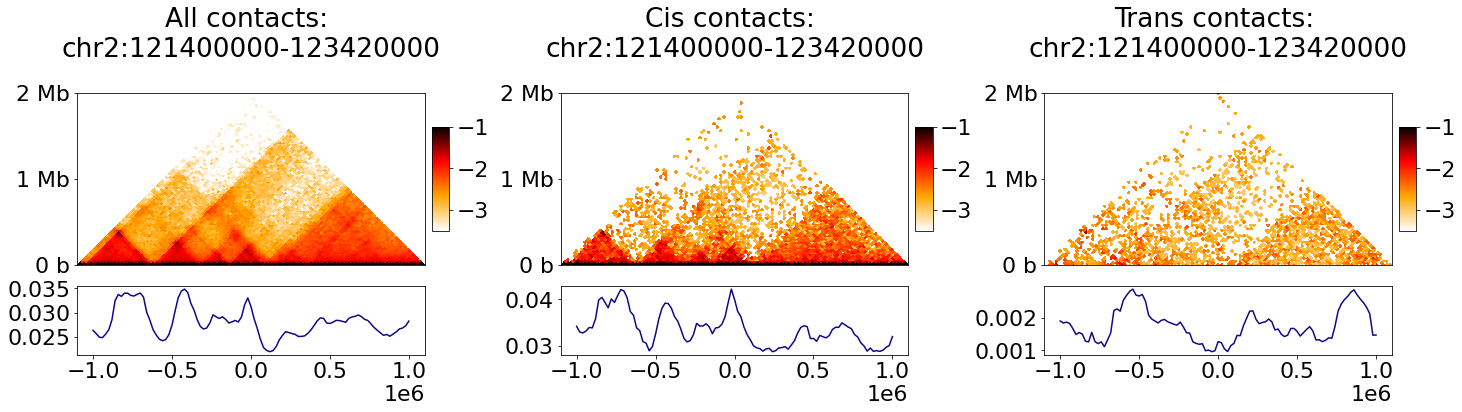

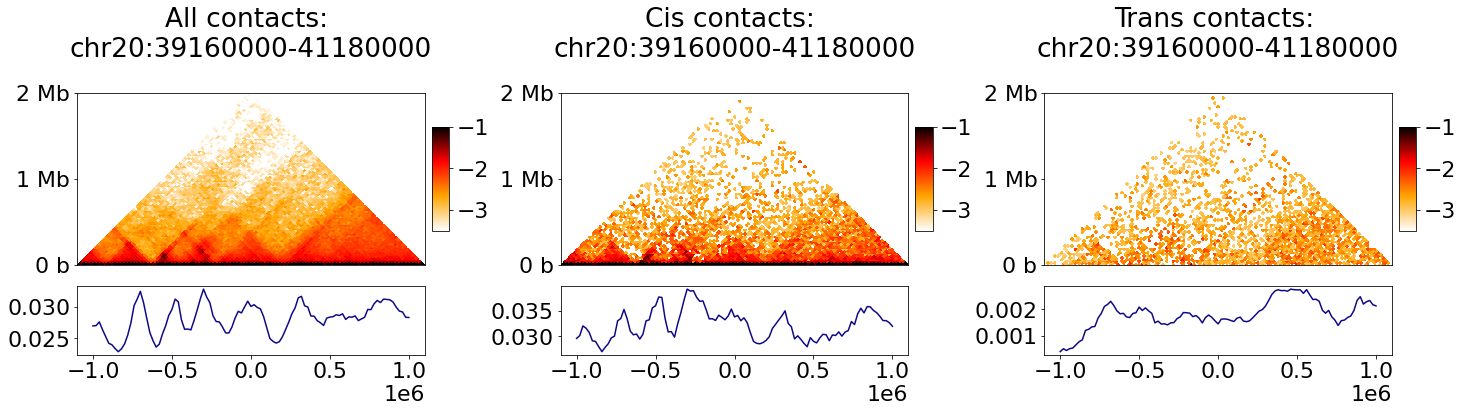

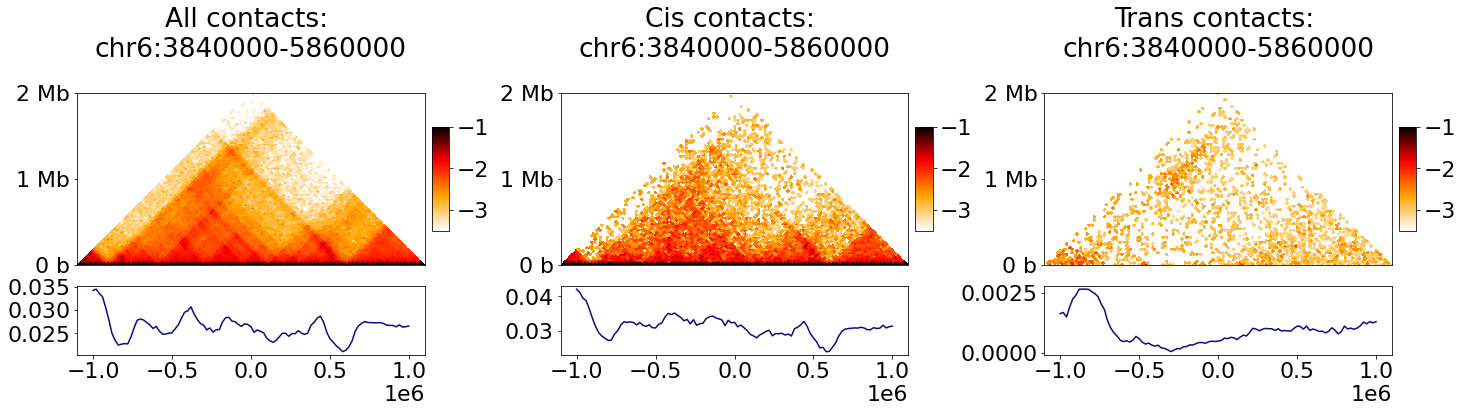

In [14]:
for _, row in windows.iterrows():
    
    coord = f"{row.chrom}:{row.start}-{row.end}"
    
    f, ax = plt.subplots(figsize=(24, 8), ncols=3)
    plt.subplots_adjust(wspace=0.3)
    for index, rType in enumerate(["all", "cis", "trans"]):
        # plot the matrices for all, cis and trans maps
        matrix = clrs[rType].matrix(balance=True).fetch(coord)
        temp = np.log10(matrix).copy()
        im = pcolormesh_45deg(ax[index], 
                              temp, 
                              start=row.start, 
                              resolution=resolution, 
                              vmin=-3.5, 
                              vmax=-1, 
                              cmap=cmapFall)
        ax[index].set_aspect(0.5)
        ax[index].set_ylim(0, 2*10**6)
        format_ticks(ax[index], rotate=False)
        ax[index].xaxis.set_visible(False)
        ax[index].set_title(f"{rType} Contacts: \n{coord}\n".capitalize ())
        
        # add the colorbar
        divider = make_axes_locatable(ax[index])
        cax = divider.append_axes("right", size="5%", pad=0.1, aspect=6)
        plt.colorbar(im, cax=cax)
        
        # get the pairing score and plot it for each matrix 
        pairingScore = [element for element in pairingScore_profiles if element['condition'] == coord
                           and element['rType'] == rType][0]['data']  
        pairingScore ['mid'] = pairingScore ['mid'] - np.median (pairingScore['mid'])        
        ins_ax = divider.append_axes("bottom", size="20%", pad= -0.9)
        ins_ax.set_prop_cycle(plt.cycler("color", plt.cm.plasma(np.linspace(0,1,5))))
        ins_ax.plot(pairingScore['mid'], pairingScore['PairingScore'], label = f"{coord}")    